## Titanic Survival Prediction Model with Machine Learning

Using the Titanic dataset from [this](https://www.kaggle.com/c/titanic/overview) Kaggle competition.

This dataset contains information about 891 people who were on board the ship when departed on April 15th, 1912. As noted in the description on Kaggle's website, some people aboard the ship were more likely to survive the wreck than others. There were not enough lifeboats for everybody so women, children, and the upper-class were prioritized. Using the information about these 891 passengers, the challenge is to build a model to predict which people would survive based on the following fields:

- **Name** (str) - Name of the passenger
- **Pclass** (int) - Ticket class
- **Sex** (str) - Sex of the passenger
- **Age** (float) - Age in years
- **SibSp** (int) - Number of siblings and spouses aboard
- **Parch** (int) - Number of parents and children aboard
- **Ticket** (str) - Ticket number
- **Fare** (float) - Passenger fare
- **Cabin** (str) - Cabin number
- **Embarked** (str) - Port of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)

# Imports

In [69]:
#Imports
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns #as allows us to reference this library by the as name
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [42]:
titanic = pd.read_csv('titanic.csv')

# Drop irrelevant continuous variable
titanic.drop('PassengerId', axis=1, inplace=True)

titanic.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## EDA & Cleaning: Exploring continuous features

First we'll explore the continuous features of the model.

In [43]:
# Drop all categorical features

cat_feat = ['Name', 'Ticket', 'Sex', 'Cabin', 'Embarked']

titanicCat = titanic.drop(cat_feat, axis=1)
titanicCat.head() #prints first five rows

,Survived,Pclass,Age,SibSp,Parch,Fare
0,0,3,22.0,1,0,7.2500
1,1,1,38.0,1,0,71.2833
2,1,3,26.0,0,0,7.9250
3,1,1,35.0,1,0,53.1000
4,0,3,35.0,0,0,8.0500


Notes:
- axis 1 lets pandas know we're dropping the collums not the rows
- axis=0 would drop the rows
- inplace=True performs operation on existing variable instead of creating a new one. For this notebook we've changed the variable, but this will be useful later.

In [44]:
titanicCat.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Observations: 

- Here, count for age is lower than the rest. This indicates missing data here
- Survived is our target variable. The mean therefore tells us the avg of people who survived. That means 38% of people survived
- Integer varaibles - Pclass, SibSp, Parch
    - These are Ordinal (def: Catagorical variables whose values are ordered) That is, integers that are only specific levels
    - For example Pclass = 1st, 2nd, 3rd class

# To determine what data is useful, we must determine which variables are strong indicators of whether a passanger survived or died.

HOW?
- dependant on our target varaible
- Here, using a binary of "Survived", we could determine the avg of the other variables

In [45]:
# Here we've grouped the dataset by who has survived and who did not
#then, .mean calls the average for every feature based on the groups
titanicCat.groupby('Survived').mean()

,Pclass,Age,SibSp,Parch,Fare
Survived,,,,,
0,2.531876,30.626179,0.553734,0.329690,22.117887
1,1.950292,28.343690,0.473684,0.464912,48.395408


 # Which things in our dataset stand out?

- Fare has a large difference
- Class has a large difference as well

# Missing Data
AGE has some missing data numbers. To deal with this, first determine HOW this data is missing
- RANDOMLY (Ex: Certain passangers never had their age recorded)
- SYSTEMATICALLY (Ex: All first class passangers were not asked for their age)

This informs how we handle missing values in our datasets.

In [46]:
#To solve this, we can group our dataset by whether age is missing or not.
titanicCat.groupby(titanicCat['Age'].isnull()).mean()

,Survived,Pclass,Age,SibSp,Parch,Fare
Age,,,,,,
False,0.406162,2.236695,29.699118,0.512605,0.431373,34.694514
True,0.293785,2.598870,NaN,0.564972,0.180791,22.158567


- Note here that 'true" means true for the statement "isnull"!

Conclusion: Age seems to be missing at random.

In [47]:
#Because it seems the ages are missing at random, we'll replace the missing
#values with the average value for that feature
#This satisfies our data model with biasing the model

titanic['Age'].fillna(titanic['Age'].mean(), inplace=True)
titanic.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age           0
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

# Plot Overlayed Histograms
- shows us the actual distrubution instead of just the mean

Code Observations:
since a lot of the same calculations have to be done on the seperate lists of groupings 'Survived' and 'Not Survived', the iteration here is the strings that are passed to the list function to index the collum of the trait we want to list. Kinda brilliant.

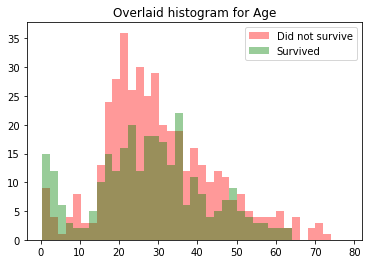

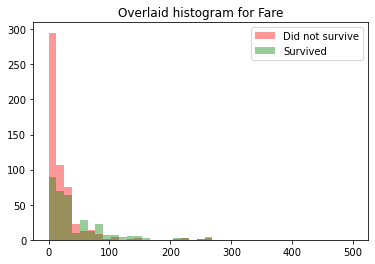

In [14]:
for i in ['Age', 'Fare']:
    died = list(titanicCat[titanicCat['Survived'] == 0][i].dropna())
    survived = list(titanicCat[titanicCat['Survived'] == 1][i].dropna())
    xmin = min(min(died), min(survived))
    xmax = max(max(died), max(survived))
    width = (xmax - xmin) / 40
    sns.distplot(died, color='r', kde=False, bins=np.arange(xmin, xmax, width))
    sns.distplot(survived, color='g', kde=False, bins=np.arange(xmin, xmax, width))
    plt.legend(['Did not survive', 'Survived'])
    plt.title('Overlaid histogram for {}'.format(i))
    plt.show()

Here, the survial rate based on fare looks rather same except for the first two bars. This is where looking at means only is dangerous as the average is likely being affected by the outliers here.

<Figure size 432x288 with 0 Axes>

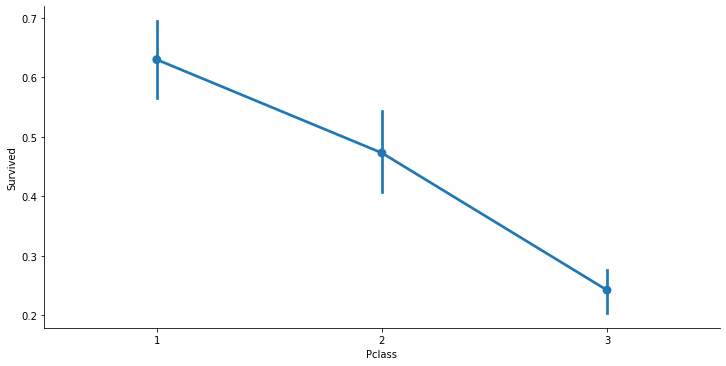

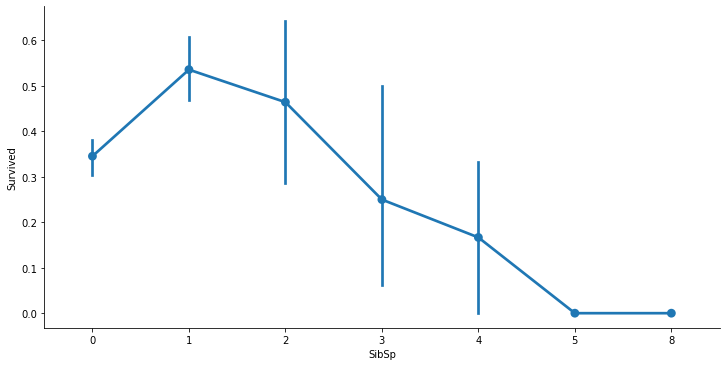

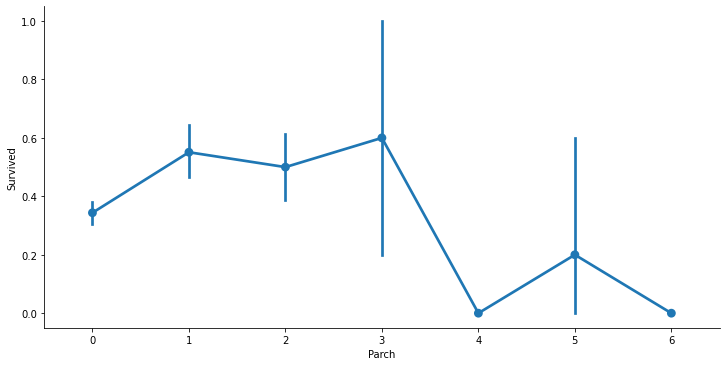

In [15]:
#aspect controls size, data is our data object, kind is the type of graph we're
#creating.
#Here we again are looping through the indexes but for ever iterative loop
#we need a new table!
for i, col in enumerate(['Pclass', 'SibSp', 'Parch']):
    plt.figure(i)
    sns.catplot(x=col, y='Survived', data=titanic, kind='point', aspect=2,)
#enumerate here returns both the index of each list object and the object itself
#passing i creates a new plot based on the index value and we can use
#col for our x value

In our figures, each point relates to the percentage of people who survived 
with each x value. Ex: 63% of first class passangers survived.

The vertical bars indicate the possible margin or error

Clearly, class had a lot to do with survivability.
Also, SibSp and Parch both have to do with the number of family members you have abord. As the survivability rate lowers with the more family members you have, we can now look at the possibility of combining these features.

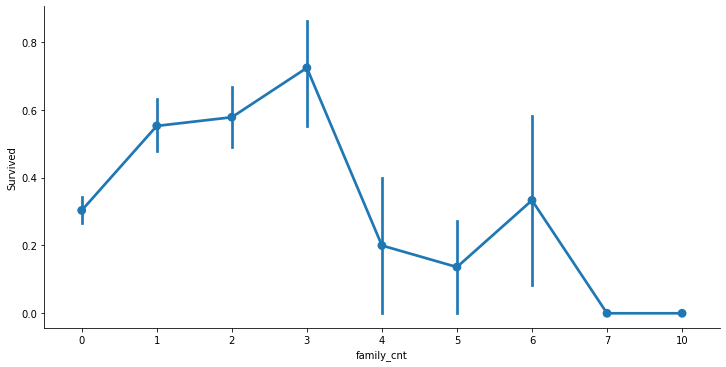

In [48]:
titanic['family_cnt'] = titanic['SibSp'] + titanic['Parch']
sns.catplot(x='family_cnt', y='Survived', data=titanic, kind='point', aspect=2,)

Because the trend we saw in the previous two graphs continues here, we can safely say the more family you have aboard, the less likely you are to survive.

**IF YOU CAN COMBINE TWO FEATURES INTO ONE WHILE STILL MAINTAINING THE PATTERN OR TREND IT IS USUALLY A GOOD IDEA TO DO SO!**
This cleans up our data so we only have to use the family_cnt feature going forward.

In [49]:
#Now we have to drop SibSp and Parch to avoid mutlico-linearity
titanic.drop(['SibSp', 'Parch'], axis=1, inplace=True)
titanic.head()

,Survived,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked,family_cnt
0,0,3,"Braund, Mr. Owen Harris",male,22.0,A/5 21171,7.2500,NaN,S,1
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,PC 17599,71.2833,C85,C,1
2,1,3,"Heikkinen, Miss. Laina",female,26.0,STON/O2. 3101282,7.9250,NaN,S,0
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,113803,53.1000,C123,S,1
4,0,3,"Allen, Mr. William Henry",male,35.0,373450,8.0500,NaN,S,0


# Explore Catagorical Features

Explore `Sex`, `Cabin`, and `Embarked`.

In [50]:
# Drop all continuous features
cont_feat = ['Pclass', 'Name', 'Fare']
titanicCont = titanic.drop(cont_feat, axis=1)
titanicCont.head()

,Survived,Sex,Age,Ticket,Cabin,Embarked,family_cnt
0,0,male,22.0,A/5 21171,NaN,S,1
1,1,female,38.0,PC 17599,C85,C,1
2,1,female,26.0,STON/O2. 3101282,NaN,S,0
3,1,female,35.0,113803,C123,S,1
4,0,male,35.0,373450,NaN,S,0


In [52]:
titanicCont.info() #this tells us how many non-null entries plus type

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    891 non-null    int64  
 1   Sex         891 non-null    object 
 2   Age         891 non-null    float64
 3   Ticket      891 non-null    object 
 4   Cabin       204 non-null    object 
 5   Embarked    889 non-null    object 
 6   family_cnt  891 non-null    int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 48.9+ KB


In [53]:
#Groups by whether cabin is entered or not and calcs avg survival rate
titanicCont.groupby(titanic['Cabin'].isnull()).mean

<bound method GroupBy.mean of <pandas.core.groupby.generic.DataFrameGroupBy object at 0x0000020AEDD61160>>

Those who had cabin marked down were more likely to survive. Ergo, not random

In theory, having missing values, we would drop this catagory. But, upon exploration we've found a useful trend in the data.

Solution? Lets create a binary value that indicates whether someone has a cabin or not.

In [55]:
#Inserts 0 if cabin val is null, 1 if not
titanic['Cabin_ind'] = np.where(titanic['Cabin'].isnull(), 0, 1)
titanic.head(10)

,Survived,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked,family_cnt,Cabin_ind
0,0,3,"Braund, Mr. Owen Harris",male,22.000000,A/5 21171,7.2500,NaN,S,1,0
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,PC 17599,71.2833,C85,C,1,1
2,1,3,"Heikkinen, Miss. Laina",female,26.000000,STON/O2. 3101282,7.9250,NaN,S,0,0
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,113803,53.1000,C123,S,1,1
4,0,3,"Allen, Mr. William Henry",male,35.000000,373450,8.0500,NaN,S,0,0
5,0,3,"Moran, Mr. James",male,29.699118,330877,8.4583,NaN,Q,0,0
6,0,1,"McCarthy, Mr. Timothy J",male,54.000000,17463,51.8625,E46,S,0,1
7,0,3,"Palsson, Master. Gosta Leonard",male,2.000000,349909,21.0750,NaN,S,4,0
8,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.000000,347742,11.1333,NaN,S,2,0
9,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.000000,237736,30.0708,NaN,C,1,0


### Plot categorical features

<Figure size 432x288 with 0 Axes>

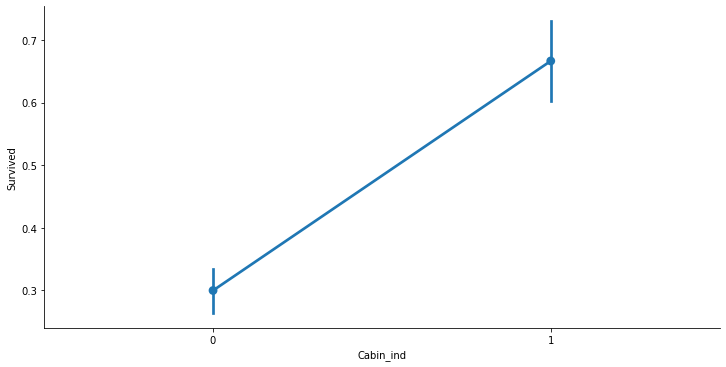

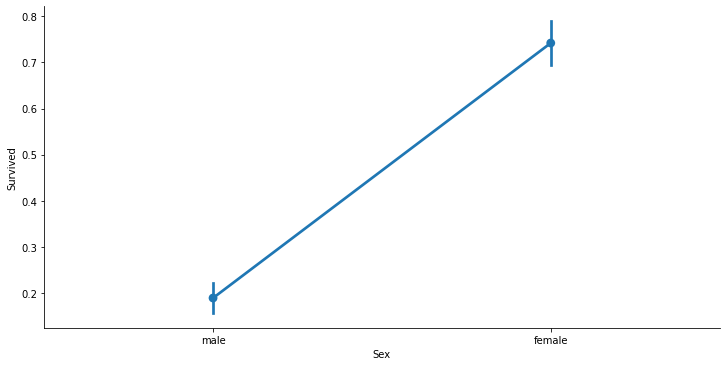

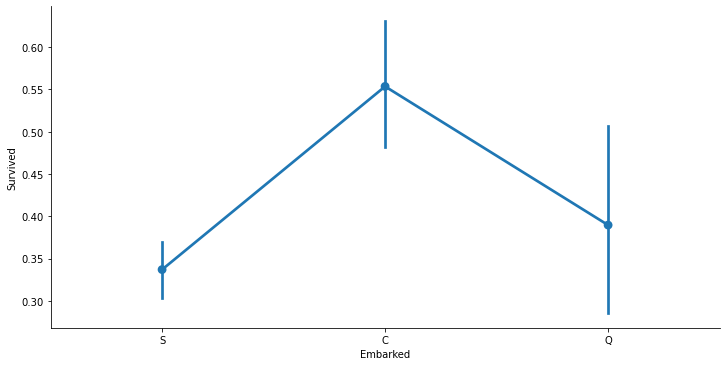

In [56]:
for i, col in enumerate(['Cabin_ind', 'Sex', 'Embarked']):
    plt.figure(i)
    sns.catplot(x=col, y='Survived', data=titanic, kind='point', aspect=2, )

Analysis:
Those with cabins were much more likely to survive
Women were much more likely to survive than men

While there looks to be a seperatiion in the embarked catagory, this is where some common sense must be applied. It's unlikely that where they boarded truly determined whether they survived or not. Likely, this difference is already being displayed in our data through other factors. For example, if one of these towns is a rich town then it is likely man wealtheir passangers with more expensive fares, higher class, and a cabin boarded there- but these factors are already included in our dataset.
We can explore these ideas by using some pivot tables

In [57]:
titanic.pivot_table('Survived', index='Sex', columns='Embarked', aggfunc='count')

Embarked,C,Q,S
Sex,,,
female,73,36,203
male,95,41,441


In Southhampton, double the amount of men boarded rather than women which can
explain why the survival rate based on embarkation is much higher as we already
known women were much more likely to survive than men

In [58]:
titanic.pivot_table('Survived', index='Cabin_ind', columns='Embarked', aggfunc='count')

Embarked,C,Q,S
Cabin_ind,,,
0,99,73,515
1,69,4,129


Likewise, much more people in C boarded with a cabin which we've arleady linked
to the survival rate. Therefore, the embarked is repetitive and unnescesary

# Finishing the Cleaning

In [59]:
titanic.drop(['Name', 'Ticket'], axis=1, inplace=True)
titanic.head()

,Survived,Pclass,Sex,Age,Fare,Cabin,Embarked,family_cnt,Cabin_ind
0,0,3,male,22.0,7.2500,NaN,S,1,0
1,1,1,female,38.0,71.2833,C85,C,1,1
2,1,3,female,26.0,7.9250,NaN,S,0,0
3,1,1,female,35.0,53.1000,C123,S,1,1
4,0,3,male,35.0,8.0500,NaN,S,0,0


### Create indicator for `Cabin`

In [60]:
#np.where is basically an if statement
titanic['Cabin_ind'] = np.where(titanic['Cabin'].isnull(), 0, 1)
titanic.head()

,Survived,Pclass,Sex,Age,Fare,Cabin,Embarked,family_cnt,Cabin_ind
0,0,3,male,22.0,7.2500,NaN,S,1,0
1,1,1,female,38.0,71.2833,C85,C,1,1
2,1,3,female,26.0,7.9250,NaN,S,0,0
3,1,1,female,35.0,53.1000,C123,S,1,1
4,0,3,male,35.0,8.0500,NaN,S,0,0


### Convert `Sex` to numeric

In [61]:
gender_num = {'male': 0, 'female': 1}

#this replaces our str gender values with numerical ones
titanic['Sex'] = titanic['Sex'].map(gender_num)
titanic.head(10)

,Survived,Pclass,Sex,Age,Fare,Cabin,Embarked,family_cnt,Cabin_ind
0,0,3,0,22.000000,7.2500,NaN,S,1,0
1,1,1,1,38.000000,71.2833,C85,C,1,1
2,1,3,1,26.000000,7.9250,NaN,S,0,0
3,1,1,1,35.000000,53.1000,C123,S,1,1
4,0,3,0,35.000000,8.0500,NaN,S,0,0
5,0,3,0,29.699118,8.4583,NaN,Q,0,0
6,0,1,0,54.000000,51.8625,E46,S,0,1
7,0,3,0,2.000000,21.0750,NaN,S,4,0
8,1,3,1,27.000000,11.1333,NaN,S,2,0
9,1,2,1,14.000000,30.0708,NaN,C,1,0


### Drop `Cabin` and `Embarked`

In [62]:
titanic.drop(['Embarked', 'Cabin'], axis=1, inplace=True)
titanic.head(5)

,Survived,Pclass,Sex,Age,Fare,family_cnt,Cabin_ind
0,0,3,0,22.0,7.2500,1,0
1,1,1,1,38.0,71.2833,1,1
2,1,3,1,26.0,7.9250,0,0
3,1,1,1,35.0,53.1000,1,1
4,0,3,0,35.0,8.0500,0,0


In [67]:
#Write out the cleaned data
titanic.to_csv('titanic_cleaned.csv', index=False)

## Measuring Success: Splitting up the data for train, validation, and test set

Split the dataset up into the following segments:
1. Training Data: 60%
2. Validation Data: 20%
3. Test Data: 20%

In [65]:
features = titanic.drop('Survived', axis=1)
labels = titanic['Survived']


#this method splits both features and labels so it outputs 4 datasets
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.4, random_state=42)

#because we can't split into three, we must split the data again
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

In [66]:
#Lets check and make sure they were split properly!

print(len(labels), len(y_train), len(y_val), len(y_test))

891 534 179 178


- x_train and y_train are 60% of the data
- x_test and y_test is 20% of our data
- x_val and y_val are the remaining 20%

The last two are uneven because we had an odd number, but this is accurate. yay!

### Write out data

In [ ]:
X_train.to_csv('train_features.csv', index=False)
X_val.to_csv('val_features.csv', index=False)
X_test.to_csv('test_features.csv', index=False)

y_train.to_csv('train_labels.csv', index=False)
y_val.to_csv('val_labels.csv', index=False)
y_test.to_csv('test_labels.csv', index=False)

In [ ]:
tr_features = pd.read_csv('train_features.csv')
tr_labels = pd.read_csv('train_labels.csv', header=None)
val_features = pd.read_csv('val_features.csv')
val_labels = pd.read_csv('val_labels.csv', header=None)

te_features = pd.read_csv('test_features.csv')
te_labels = pd.read_csv('test_labels.csv', header=None)

In [ ]:
rf = RandomForestClassifier()

#.values.ravel() translates this collum vector to an array which is more efficient
scores = cross_val_score(rf, tr_features, tr_labels.values.ravel(), cv=5)

print(scores)

In [ ]:
def print_results(results):
    #For every hyperparameter combination, will print out standard accurarcy and deviation accross the five folds 
    print('BEST PARAMS: {}\n'.format(results.best_params_))

    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print('{} (+/-{}) for {}'.format(round(mean, 3), round(std * 2, 3), params))

In [ ]:
rf = RandomForestClassifier()
parameters = {
    #How many decisions trees built in the rf
    'n_estimators': [5, 50, 100],
    #Height of the decision tree
    'max_depth': [2, 10, 20, None]
}

cv = GridSearchCV(rf, parameters, cv=5)
cv.fit(tr_features, tr_labels.values.ravel())

print_results(cv)

### Fit best models on full training set (SAMPLE OUTPUT)

Results from last section:
```
0.76 (+/-0.116) for {'max_depth': 2, 'n_estimators': 5}
0.796 (+/-0.119) for {'max_depth': 2, 'n_estimators': 50}
0.803 (+/-0.117) for {'max_depth': 2, 'n_estimators': 100}
--> 0.828 (+/-0.074) for {'max_depth': 10, 'n_estimators': 5}
0.816 (+/-0.028) for {'max_depth': 10, 'n_estimators': 50}
--> 0.826 (+/-0.046) for {'max_depth': 10, 'n_estimators': 100}
0.785 (+/-0.106) for {'max_depth': 20, 'n_estimators': 5}
0.813 (+/-0.027) for {'max_depth': 20, 'n_estimators': 50}
0.809 (+/-0.029) for {'max_depth': 20, 'n_estimators': 100}
0.794 (+/-0.04) for {'max_depth': None, 'n_estimators': 5}
0.809 (+/-0.037) for {'max_depth': None, 'n_estimators': 50}
--> 0.818 (+/-0.035) for {'max_depth': None, 'n_estimators': 100}
```

In [ ]:
#We'l use the top three preformers for our final testing...

rf1 = RandomForestClassifier(n_estimators=5, max_depth=10)
rf1.fit(tr_features, tr_labels.values.ravel())

rf2 = RandomForestClassifier(n_estimators=100, max_depth=10)
rf2.fit(tr_features, tr_labels.values.ravel())

rf3 = RandomForestClassifier(n_estimators=100, max_depth=None)
rf3.fit(tr_features, tr_labels.values.ravel())

In [ ]:
for mdl in [rf1, rf2, rf3]:
    y_pred = mdl.predict(val_features)
    accuracy = round(accuracy_score(val_labels, y_pred), 3)
    precision = round(precision_score(val_labels, y_pred), 3)
    recall = round(recall_score(val_labels, y_pred), 3)
    print('MAX DEPTH: {} / # OF EST: {} -- A: {} / P: {} / R: {}'.format(mdl.max_depth,
                                                                         mdl.n_estimators,
                                                                         accuracy,
                                                                         precision,
                                                                         recall))

In [ ]:
y_pred = rf2.predict(te_features)
accuracy = round(accuracy_score(te_labels, y_pred), 3)
precision = round(precision_score(te_labels, y_pred), 3)
recall = round(recall_score(te_labels, y_pred), 3)
print('MAX DEPTH: {} / # OF EST: {} -- A: {} / P: {} / R: {}'.format(rf2.max_depth,
                                                                     rf2.n_estimators,
                                                                     accuracy,
                                                                     precision,
                                                                     recall))